# Identify Contrails with Keras (Threshold Analysis)

In [1]:
# reinstall tensorflow-io
# to avoid the UserWarning: unable to load libtensorflow_io_plugins.so

#!pip install tensorflow-io

In [2]:
#%cp ../input/identify-contrails-weights-v8/weights_v8_contrails-unet_cst-lr.h5 .
#%mv weights_v8_contrails-unet_cst-lr.h5 contrails-unet_cst-lr.h5

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import datetime
import math
import pathlib
import random
import shutil

from pytz import timezone

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
PRINT_TIME_FORMAT = "%Y-%m-%d %H:%M:%S %Z%z"
FILE_TIME_FORMAT = "%Y-%m-%d_%H-%M-%S"

In [5]:
file_time = datetime.datetime.now().strftime(FILE_TIME_FORMAT)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as backend

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
tf.__version__

'2.12.0'

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [9]:
%pwd

'/kaggle/working'

In [10]:
#---------------------------------------------------------------------------79

Following U-Net model is adapted from:
- https://keras.io/examples/vision/oxford_pets_image_segmentation
- https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580

# Setup

In [11]:
WORK_DIR = '/kaggle/working'  # preserved if notebook is saved
TEMP_DIR = '/kaggle/temp'  # just during current session

DATA_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'

class Paths:
    train = os.path.join(DATA_DIR, 'train')
    valid = os.path.join(DATA_DIR, 'validation')
    test = os.path.join(DATA_DIR, 'test')

In [12]:
train_ids = os.listdir(Paths.train)
valid_ids = os.listdir(Paths.valid)
test_ids = os.listdir(Paths.test)
print(len(train_ids), len(valid_ids), len(test_ids))

20529 1856 2


In [13]:
class ABI:
    bands = {name: idx for idx, name in enumerate([
        '08', '09', '10', '11', '12', '13', '14', '15', '16'])}
    colors = {name: idx for idx, name in enumerate([
        'red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black'])}

In [14]:
N_TIMES_BEFORE = 4
N_TIMES_AFTER = 3

In [15]:
def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def get_ash_colors(sample_id, split_dir):
    """
    Based on bands: 11, 14, 15
    
    Args:
        sample_id(str): The id of the example i.e. '1000216489776414077'
        split_dir(str): The split directoryu i.e. 'test', 'train', 'val'
    """
    band15 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_15.npy")
    band14 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_14.npy")
    band11 = np.load(DATA_DIR + f"/{split_dir}/{sample_id}/band_11.npy")

    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    ash_colors = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    
    return ash_colors

In [16]:
def get_individual_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_individual_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

In [17]:
def get_pixel_mask(sample_id, split_dir):
    masks_path = DATA_DIR + f"/{split_dir}/{sample_id}/human_pixel_masks.npy"
    pixel_mask = np.load(masks_path)
    return pixel_mask

### Check some values (DEVEL)

In [18]:
sample_id = train_ids[3]

ash_colors = get_ash_colors(sample_id, 'train')[..., N_TIMES_BEFORE]

print(ash_colors.shape)
for color in range(3):
    array = ash_colors[..., color]
    print(array.min(), array.max())

(256, 256, 3)
0.0 0.50921124
0.097476535 0.86938816
0.031865694 0.81146187


In [19]:
pixel_mask = get_pixel_mask(sample_id, 'train')

print(pixel_mask.shape)
print(pixel_mask.min(), pixel_mask.max())

(256, 256, 1)
0 1


# Model

In [20]:
SEED = 42

In [21]:
class Config:
    
    img_size = (256, 256)
    
    num_epochs = 10  # <DEVEL> else 10
    num_classes = 1
    batch_size = 16  # <DEVEL> else 32
    
    threshold = 0.40
    
    seed = SEED

In [22]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
keras.utils.set_random_seed(Config.seed)

# See also:
# tf.config.experimental.enable_op_determinism()

Model inspired by:
- https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/
- file:///D:/Courses/2023-07_Advanced-Computer-Vision-with-TensorFlow/lecture-notes/C3_W3_Image-Segmentation.pdf

In [23]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    x = input_tensor
    for i in range(2):
        x = tf.keras.layers.SeparableConv2D(
            filters = n_filters, kernel_size=(kernel_size, kernel_size), padding='same')(x)
        #? kernel_initializer = 'he_normal'
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

In [24]:
def encoder_block(inputs, n_filters, pool_size, dropout):
    f = conv2d_block(inputs, n_filters=n_filters)
    p = tf.keras.layers.MaxPooling2D(pool_size)(f)
    p = tf.keras.layers.Dropout(dropout)(p)
    return f, p

In [25]:
def encoder(inputs, dropout=0.1):
    f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=dropout)
    f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=dropout)
    f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=dropout)
    f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=dropout)
    return p4, (f1, f2, f3, f4)

In [26]:
def bottleneck(inputs):
    bottle_neck = conv2d_block(inputs, n_filters=1024)
    return bottle_neck

In [27]:
def decoder_block(inputs, conv_output, n_filters, kernel_size, strides, dropout):
    u = tf.keras.layers.Conv2DTranspose(
        n_filters, kernel_size, strides=strides, padding = 'same')(inputs)
    u = tf.keras.layers.BatchNormalization()(u)
    c = tf.keras.layers.concatenate([u, conv_output])
    c = tf.keras.layers.Dropout(dropout)(c)
    c = conv2d_block(c, n_filters, kernel_size=3)
    return c

In [28]:
def decoder(inputs, convs, num_classes, dropout=0.1):
    f1, f2, f3, f4 = convs
    c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=dropout)
    c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=dropout)
    c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=dropout)
    c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=dropout)
    if num_classes == 1:
        activation = "sigmoid"
    else:
        activation = "softmax"
    outputs = layers.Conv2D(num_classes, kernel_size=3, activation=activation, padding="same")(c9)
    return outputs

In [29]:
def unet(image_size, num_classes):
    inputs = tf.keras.layers.Input(shape=(image_size,image_size,3))
    encoder_output, convs = encoder(inputs)
    #model = tf.keras.Model(inputs=inputs, outputs=encoder_output)  # debug
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs, num_classes)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [30]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
#model = get_model(Config.img_size, Config.num_classes)
model = unet(image_size=256, num_classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 64  283        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['separable_conv2d[0][0]']       
 alization)                     )                                                             

# Prepare datasets

In [31]:
N_SAMPLES = None  # None to take all
N_PARTIAL = 128  # 128

In [32]:
class AshColorSingleFrames(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, sample_ids, split_dir, n_samples=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.split_dir = split_dir
        self.sample_ids = sample_ids[:n_samples]

    def __len__(self):
        return math.ceil(len(self.sample_ids) / self.batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_sample_ids = self.sample_ids[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, sample_id in enumerate(batch_sample_ids):
            img = get_ash_colors(sample_id, self.split_dir)
            x[j] = img[..., N_TIMES_BEFORE]

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        if self.split_dir != 'test':
            for j, sample_id in enumerate(batch_sample_ids):
                img = get_pixel_mask(sample_id, self.split_dir)
                y[j] = img
        
        return x, y

In [33]:
train_set = AshColorSingleFrames(Config.batch_size, Config.img_size, train_ids, 'train',
                                 n_samples=N_SAMPLES)  # <DEVEL>
print('number of batches:', len(train_set))

number of batches: 1284


In [34]:
valid_set = AshColorSingleFrames(Config.batch_size, Config.img_size, valid_ids, 'validation',
                                 n_samples=N_SAMPLES)  # <DEVEL>
print('number of batches:', len(valid_set))

number of batches: 116


In [35]:
partial_set = AshColorSingleFrames(Config.batch_size, Config.img_size, valid_ids, 'validation',
                                 n_samples=N_PARTIAL)  # <DEVEL>
print('number of batches:', len(partial_set))

number of batches: 8


In [36]:
test_set = AshColorSingleFrames(Config.batch_size, Config.img_size, test_ids, 'test')
print('number of batches:', len(test_set))

number of batches: 1


Check batch dimensions (x, y):

In [37]:
train_set[0][0].shape, train_set[0][1].shape

((16, 256, 256, 3), (16, 256, 256, 1))

# Training

`dice_coef` adapted from:
- https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
- https://www.kaggle.com/code/shashwatraman/simple-unet-baseline-train-lb-0-580

In [38]:
def dice_coef(y_true, y_pred, smooth=0.001, threshold=None):
    y_true_f = backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = backend.flatten(tf.cast(y_pred, tf.float32))
    # ValueError: No gradients provided for any variable
    if threshold is not None:
        y_pred_f = backend.flatten(
            tf.cast(tf.math.greater(tf.cast(y_pred, tf.float32), threshold), tf.float32))
    intersection = backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (backend.sum(y_true_f) + backend.sum(y_pred_f) + smooth)
    return dice

def threshold_dice_coef(y_true, y_pred, smooth=0.001):
    return dice_coef(y_true, y_pred, smooth=smooth, threshold=Config.threshold)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

Check `dice_coef()` on one of the samples.

In [39]:
sample_id = train_ids[3]

merged_mask = get_pixel_mask(sample_id, 'train')
indiv_masks = get_individual_mask(sample_id, 'train')

print(dice_coef(tf.convert_to_tensor(merged_mask),
                tf.convert_to_tensor(merged_mask)))
for idv in range(6):
    print(dice_coef(tf.convert_to_tensor(merged_mask),
                    tf.convert_to_tensor(indiv_masks[..., idv])))

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.8743467, shape=(), dtype=float32)
tf.Tensor(0.83587146, shape=(), dtype=float32)
tf.Tensor(0.7393573, shape=(), dtype=float32)
tf.Tensor(0.8522139, shape=(), dtype=float32)
tf.Tensor(0.87988245, shape=(), dtype=float32)
tf.Tensor(0.84089667, shape=(), dtype=float32)


Learning rate scheduler:
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecay - warmup only from v2.13.1 on

In [40]:
initial_learning_rate = 0.01
decay_steps = len(train_set)
decay_rate = 0.7

cos_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps)

exp_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)

In [41]:
checkpoint_path = f"contrails_{file_time}.h5"
print(f'checkpoint file: {checkpoint_path}')

checkpoint file: contrails_2023-07-15_14-45-50.h5


In [42]:
checkpoint_path = "weights_v8_contrails-unet_cst-lr.h5"

# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=[dice_coef])
#model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef])

callbacks = [
    #keras.callbacks.LearningRateScheduler(exp_scheduler),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
]

In [43]:
TRAIN = False

if TRAIN:
    # Train the model, doing validation at the end of each epoch.
    model.fit(train_set, epochs=Config.num_epochs, validation_data=valid_set, callbacks=callbacks)
else:
    # Loads the weights
    model.load_weights(checkpoint_path)

Before submitting, we will have to apply the **threshold**!

In [44]:
def apply_threshold(pred, threshold):
    return (pred > threshold).astype(np.int32)

# Evaluate

In [45]:
# Evaluate the model

ALL_BATCHES = True
BATCH_IDX = 0
SAMPLE_IDX = 1

if ALL_BATCHES:
    loss, acc = model.evaluate(partial_set, verbose=2)
else:
    eval_images, eval_masks = partial_set[BATCH_IDX]
    loss, acc = model.evaluate(eval_images, eval_masks, verbose=2)

print("Saved model, accuracy: {:5.2f}%".format(100 * acc))

8/8 - 70s - loss: 0.0029 - dice_coef: 0.4164 - 70s/epoch - 9s/step
Saved model, accuracy: 41.64%


In [46]:
predictions = model.predict(partial_set)

8/8 [==============================] - 68s 8s/step


In [47]:
def eval_dice_coef(sample_set, pred_set, batch_size, threshold):
    dice_coef_per_batch = np.full(len(sample_set), np.nan)
    for idx in range(len(sample_set)):
        x, y = sample_set[idx]
        pred = pred_set[idx*batch_size:(idx + 1)*batch_size]
        _coef = dice_coef(y, pred, threshold=threshold)
        dice_coef_per_batch[idx] = _coef
    return dice_coef_per_batch

In [48]:
def dice_func(threshold):
    dice_coef_per_batch =\
        eval_dice_coef(partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
    #print(dice_coef_per_batch, dice_coef_per_batch.mean())
    return -dice_coef_per_batch.mean()

res = scipy.optimize.minimize(
    dice_func, 0.5, method='BFGS', options={'maxiter': 10, 'eps': 0.01})
print(res)
print(f'Best threshold: {res.x}')

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.5715192668139935
        x: [ 3.737e-01]
      nit: 2
      jac: [ 3.499e-02]
 hess_inv: [[ 5.804e-01]]
     nfev: 106
     njev: 47
Best threshold: [0.37370078]


In [49]:
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.6]:
    _coefs = eval_dice_coef(partial_set, predictions, batch_size=partial_set.batch_size, threshold=threshold)
    print(f'{threshold}: {_coefs.mean()}')

0.3: 0.5619918219745159
0.35: 0.56742312759161
0.4: 0.5683861449360847
0.45: 0.5639417730271816
0.5: 0.5565180405974388
0.6: 0.5315563902258873


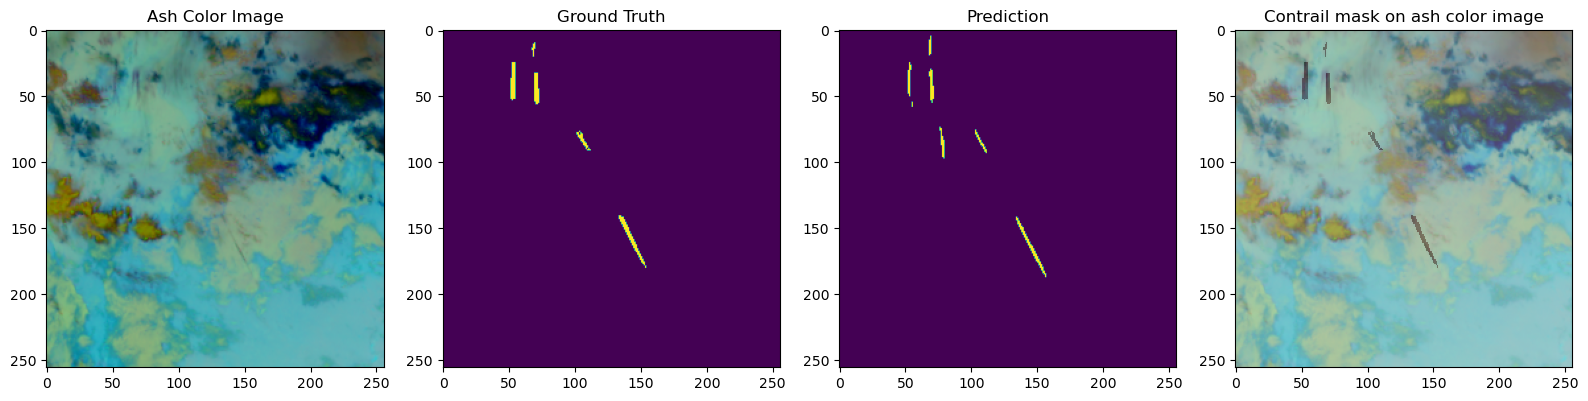

In [50]:
def plot_prediction(img, truth, pred):

    fig, axs = plt.subplots(1, 4, figsize=(16, 8))

    axs[0].imshow(img)
    axs[0].set_title("Ash Color Image")

    axs[1].imshow(truth)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred)
    axs[2].set_title("Prediction")

    axs[3].imshow(img)
    axs[3].imshow(truth, cmap='Reds', alpha=.3, interpolation='none')
    axs[3].set_title('Contrail mask on ash color image')

    plt.tight_layout() 
    plt.show()

    return

eval_images, eval_masks = partial_set[BATCH_IDX]
idx = SAMPLE_IDX
threshold = Config.threshold
plot_prediction(eval_images[idx], eval_masks[idx], apply_threshold(predictions[idx], threshold))

In [51]:
#keras.backend.clear_session()

## Make predictions on test dataset

In [52]:
predictions = model.predict(test_set)

1/1 [==============================] - 8s 8s/step


In [53]:
len(predictions)

16

## Create a submission

In [54]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


In [55]:
test_recs = os.listdir(os.path.join(DATA_DIR, 'test'))

In [56]:
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='record_id')[0:0]

for test_id, pred in zip(test_ids, predictions):
    
    mask = apply_threshold(pred, Config.threshold)
    
    # notice the we're converting rec to an `int` here:
    submission.loc[int(test_id), 'encoded_pixels'] = list_to_string(rle_encode(mask))
    
submission.to_csv('submission.csv')

In [57]:
print('Terminated', datetime.datetime.now(timezone('CET')).strftime(PRINT_TIME_FORMAT))

Terminated 2023-07-15 16:54:06 CEST+0200
